In [1]:
import ipywidgets as widgets
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import time


from matplotlib import rc 
import matplotlib.animation as animation
from collections import deque
from IPython.display import HTML

In [2]:
from functions import MS_functions_MHE, generate_meas, cnlls_solver, MHE


from animate import get_cart_x, get_cart_y, get_ball_x, get_ball_y, animate_pendulum

# Model Dynamics

In [3]:
# our parameters !
m = 1
M = 5
l = 1 # attention! l must be also changed in the animate.py file!
g = 9.81

In [4]:
# defining the rhs of the ODE system

# state variables
x1 = MX.sym('x1') #r
x2 = MX.sym('x2') #rdot
x3 = MX.sym('x3') #theta
x4 = MX.sym('x4') #thetadot
x = vertcat(x1,x2,x3,x4)

# parameter
p = MX.sym('p')

u=0

# rhs
rhs_exp = vertcat(x2,
             (-m*g*cos(x3)*sin(x3)-m*l*x4*x4*sin(x3)+u)/(M+m*sin(x3)*sin(x3)),
             x4,
             -g/l*sin(x3)+ cos(x3)/l*((-m*g*cos(x3)*sin(x3)-m*l*x4*x4*sin(x3)+u)/(M+m*sin(x3)*sin(x3)))-p/m*x4)

rhs = Function('rhs',[x,p],[rhs_exp])

# Simulation

In [5]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true = [0.5]

eps = 0.1
s0 = [0, 0, pi-eps, 0]
x0 = s0 ## initial conditions from paper
Res1 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res1 = vertcat(Res1,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
print(Res1.shape)

(404, 1)


# Simualtion with p=0 as comparison

In [6]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true2 = [0.]

eps = 0.1
s0 = [0, 0, pi-eps, 0]
x0 = s0 ## initial conditions from paper
Res2 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true2)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res2 = vertcat(Res2,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
print(Res2.shape)

(404, 1)


MovieWriter Pillow unavailable; using Pillow instead.


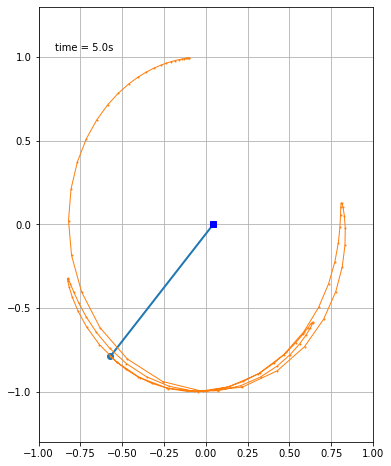

In [7]:
animate_pendulum('../plots/pendulum/simulation.gif', Res1)

In [8]:
sigma = 0.02
sigma2 = 10
M = L*N
meas = generate_meas(x, p, rhs_exp, L*T, sigma, p_true, M, x0)

In [9]:
# we need to reshape for visualization
meas1 = []
for i in range(M+1):
    meas1 = vertcat(meas1,meas[:,i])
print(meas1.shape)

(404, 1)


MovieWriter Pillow unavailable; using Pillow instead.


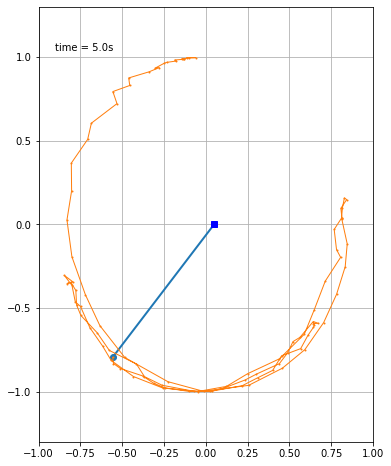

In [10]:
animate_pendulum('../plots/pendulum/measurements.gif', meas1)

# Open-loop PE for the first MHE horizon
 here the first 10 shooting intervals (->11 measurements)

In [11]:
x_opt = 0
p_opt = 0
last_P = 0
last_W = 0

In [12]:
FF1, FF2 = MS_functions_MHE(T, N, x, p, rhs_exp, meas[:,0:11], sigma,sigma2, x_opt, p_opt, last_P, last_W)

w: vertcat(S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9, p)
F1:(i0[85],i1[4])->(o0[44]) MXFunction
F2:(i0[85],i1[4])->(o0[40]) MXFunction


In [13]:
p0= [0]
w0 = vertcat(meas1[:x.shape[0]*(N+1)],np.zeros(x.shape[0]*N))
w0 = vertcat(w0,p0)
w = MX.sym('w',w0.shape[0])
#k=0
y = meas[:,10]
#print(y.shape)
F1 = Function('F1',[w],[FF1(w,y)])
F2 = Function('F2',[w],[FF2(w,y)])

In [14]:
print(F1)

F1:(i0[85])->(o0[44]) MXFunction


In [15]:
w_opt = cnlls_solver(F1, F2, w0, itmax=10, tol=1e-7, ggn = False, show_iteration = False)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |  32.00ms (  6.40ms)  32.58ms (  6.52ms)         5
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  | 261.00ms ( 65.25ms) 259.78ms ( 64.95ms)         4
   nlp_jac_g  | 174.00ms ( 29.00ms) 174.73ms ( 29.12ms)         6
       total  | 481.00ms (481.00ms) 480.86ms (480.86ms)         1


In [16]:
leng = w_opt.shape[0]
pp_opt = w_opt[leng-p.shape[0]:]
vv_opt = w_opt[(N+1)*x.shape[0]:leng-p.shape[0]]
ss_opt = w_opt[0:(N+1)*x.shape[0]]
print(pp_opt)
print(ss_opt.shape)

[-8.86484647]
(44,)


MovieWriter Pillow unavailable; using Pillow instead.


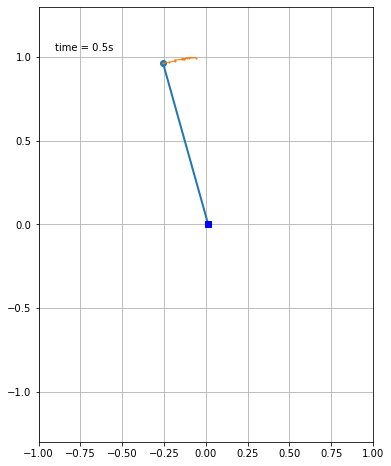

In [17]:
animate_pendulum('../plots/pendulum/ipopt_short.gif', ss_opt)

# Open-loop PE for all measurements

In [18]:
FF1, FF2 = MS_functions_MHE(L*T, L*N, x, p, rhs_exp, meas, sigma,sigma2, x_opt, p_opt, last_P, last_W)

w: vertcat(S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14, S_15, S_16, S_17, S_18, S_19, S_20, S_21, S_22, S_23, S_24, S_25, S_26, S_27, S_28, S_29, S_30, S_31, S_32, S_33, S_34, S_35, S_36, S_37, S_38, S_39, S_40, S_41, S_42, S_43, S_44, S_45, S_46, S_47, S_48, S_49, S_50, S_51, S_52, S_53, S_54, S_55, S_56, S_57, S_58, S_59, S_60, S_61, S_62, S_63, S_64, S_65, S_66, S_67, S_68, S_69, S_70, S_71, S_72, S_73, S_74, S_75, S_76, S_77, S_78, S_79, S_80, S_81, S_82, S_83, S_84, S_85, S_86, S_87, S_88, S_89, S_90, S_91, S_92, S_93, S_94, S_95, S_96, S_97, S_98, S_99, S_100, v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9, v_10, v_11, v_12, v_13, v_14, v_15, v_16, v_17, v_18, v_19, v_20, v_21, v_22, v_23, v_24, v_25, v_26, v_27, v_28, v_29, v_30, v_31, v_32, v_33, v_34, v_35, v_36, v_37, v_38, v_39, v_40, v_41, v_42, v_43, v_44, v_45, v_46, v_47, v_48, v_49, v_50, v_51, v_52, v_53, v_54, v_55, v_56, v_57, v_58, v_59, v_60, v_61, v_62, v_63, v_64, v_65, v_66, 

In [19]:
p0= [0]
w0 = vertcat(meas1,np.zeros(N*L*x.shape[0]))
w0 = vertcat(w0,p0)
ww = MX.sym('ww',w0.shape[0])
#k=0
y = meas[:,M]
#print(y.shape)
F1 = Function('F1',[ww],[FF1(ww,y)])
F2 = Function('F2',[ww],[FF2(ww,y)])

In [20]:
w_opt = cnlls_solver(F1, F2, w0, itmax=10 , tol=1e-7, ggn = False, show_iteration = False)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         4
       nlp_g  |  70.00ms ( 17.50ms)  69.13ms ( 17.28ms)         4
  nlp_grad_f  |        0 (       0)        0 (       0)         5
  nlp_hess_l  |   1.49 s (497.33ms)   1.49 s (497.58ms)         3
   nlp_jac_g  |   1.64 s (327.00ms)   1.64 s (327.12ms)         5
       total  |   3.22 s (  3.22 s)   3.22 s (  3.22 s)         1


In [21]:
len_w = w_opt.shape[0]
p_opt = w_opt[len_w-p.shape[0]:]
v_opt = w_opt[(L*N+1)*x.shape[0]:len_w-p.shape[0]]
s_opt = w_opt[0:(L*N+1)*x.shape[0]]

print(p_opt)
print(v_opt.shape)
print(s_opt.shape)

[2.06325932]
(400,)
(404,)


MovieWriter Pillow unavailable; using Pillow instead.


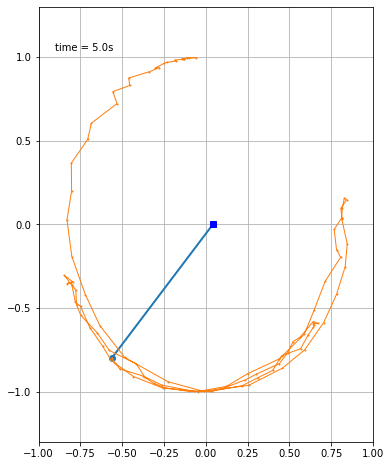

In [22]:
animate_pendulum('../plots/pendulum/ipopt.gif', s_opt)

# MHE

In [25]:
x0bar = 0
p0bar = 0
P = 0
p0 = [0.]
r0 = vertcat(meas1[:(N+1)*x.shape[0]],np.zeros(N*x.shape[0]))
r0 = vertcat(r0,p0)
print(r0.shape)
T = 0.5
N = 10
length_simulation = 15
#sigma = 0.01 (defined above)
W = 0

(85, 1)


In [26]:
xx, pp = MHE(x0bar, p0bar, P, r0, T, N, length_simulation, x, p, rhs_exp, meas, sigma,sigma2, W, ggn = False)

starting (time horizon) loop no.  1
rk- shape:  (85, 1)
w: vertcat(S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9, p)
F1:(i0[85],i1[4])->(o0[44]) MXFunction
F2:(i0[85],i1[4])->(o0[40]) MXFunction
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         2
       nlp_g  |        0 (       0)        0 (       0)         2
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  |  79.00ms ( 79.00ms)  79.16ms ( 79.16ms)         1
   nlp_jac_g  |  73.00ms ( 24.33ms)  72.22ms ( 24.07ms)         3
       total  | 156.00ms (156.00ms) 156.01ms (156.01ms)         1
starting (time horizon) loop no.  2
rk- shape:  (85, 1)
w: vertcat(S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9, p)
F1:(i0[85],i1[4])->(o0[44]) MXFunction
F2:(i0[85],i1[4])->(o0[40]) MXFunction
      solver  :   t_proc      

MovieWriter Pillow unavailable; using Pillow instead.


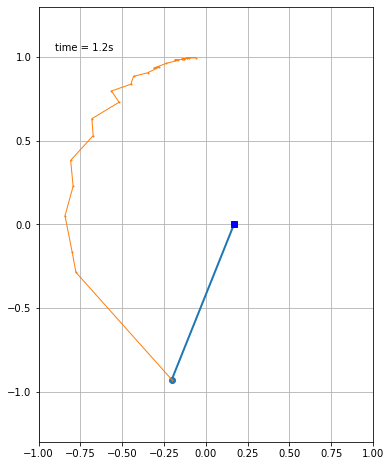

In [27]:
animate_pendulum('../plots/pendulum/mhe.gif',xx)

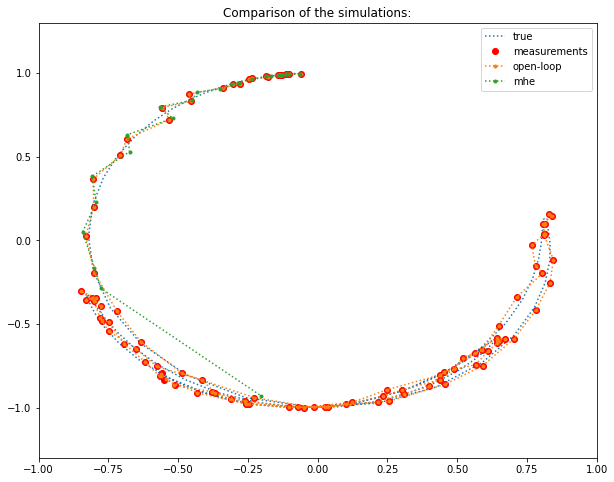

In [28]:
plt.figure(figsize=(10,8))
plt.title("Comparison of the simulations:")
plt.xlim(-1.,1.)
plt.ylim(-1.3,1.3)

ss = Res1 # true
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

ss = Res2 # true comp
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,linestyle = 'dotted', label = "true comp")   

ss = meas1 # meas
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3, 'ro',label = "measurements")#, linestyle = 'dotted') 

ss = s_opt # open-loop
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 

ss = ss_opt # open-loop short
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 

ss = xx # mhe
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)   
plt.legend()

In [29]:
def plot_widget(simulations): #, n):
    plt.figure(figsize=(10,8))
    plt.title("Comparison of the simulations:")
    plt.xlim(-1.,1.)
    plt.ylim(-1.3,1.3)
    
    
    if 'true' in simulations:
        ss = Res1 # true
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

        
    if 'measured' in simulations:
        ss = meas1 # meas
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3, 'ro',label = "measurements", ms = 5)#, linestyle = 'dotted') 
        
    if 'open-loop' in simulations:
        ss = s_opt # open-loop
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 
        
    if 'open-loop short' in simulations:
        ss = ss_opt # open-loop short
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 
        
    if 'mhe' in simulations:
        ss = xx # mhe
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)  
        
    plt.legend()
    plt.show()

In [30]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#from animate_double import plot_widget


interactive(plot_widget, simulations = widgets.SelectMultiple(
    options=['true', 'measured', 'open-loop', 'open-loop short','mhe'],
    rows = 5,
    description='Simulations:',
    disabled=False
))

interactive(children=(SelectMultiple(description='Simulations:', options=('true', 'measured', 'open-loop', 'op…

In [31]:
print(pp[pp.shape[0]-2:])
print(pp)
#print(xx.shape)

[10.2279, -39.18]
[0, 0, 0, 0, 0.0617587, -0.00388669, -0.00783061, -0.036555, -0.023948, 0.0114772, -0.0103557, 0.0327148, 0.00673357, 0.000440263, -0.0297858, 0.000600682, -0.0109386, 0.00614271, 0.00548806, -0.00300994, 0.00408929, 0.0290363, 0.0163423, -0.00483636, 0.0194132, -0.0204882, 0.00105456, 0.00231662, -0.0343815, -0.0287482, -0.00485067, 0.0241562, 0.024252, 0.0131583, 0.017067, 0.0664054, 0.00169786, 0.0115043, -0.0473484, -0.0485901, 0.0367685, 0.0617587, -0.00388669, -0.00783061, -0.036555, -0.0241759, 0.011532, -0.0100766, 0.0427927, 0.00683697, 0.000462456, -0.0296093, 0.0124032, -0.0110123, 0.00608263, 0.00595544, 0.015227, 0.00406676, 0.0292311, 0.0170534, 0.0210095, 0.0196023, -0.0204872, 0.00178264, 0.0360271, -0.0346626, -0.0288204, -0.00390615, 0.0657958, 0.034654, 0.0188265, -0.00035492, 0.0909535, -0.0368727, -0.00795837, 0.010348, 0.107591, 0.0197895, 0.0149465, -0.0123198, 0.0164066, -1.71636, -0.0241759, 0.011532, -0.0100766, 0.0427927, 0.00683687, 0.00045

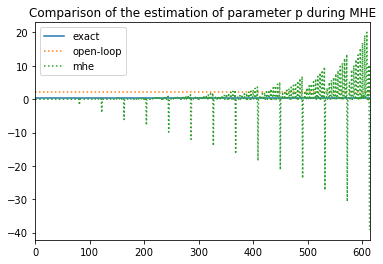

In [32]:
p_plot1 = pp
#print(p_opt[0])
p_ref1 = p_true[0]*np.ones(p_plot1.size()[0])
p_open_loop1 = p_opt[0]*np.ones(p_plot1.size()[0])

x_ax = range(p_plot1.size()[0]) 
plt.plot(x_ax,p_ref1, label = 'exact')
plt.plot(x_ax, p_open_loop1, label = 'open-loop', linestyle='dotted')
plt.plot(x_ax, p_plot1, label = 'mhe', linestyle='dotted')
plt.title('Comparison of the estimation of parameter p during MHE')
plt.xlim(0,p_plot1.size()[0])
#plt.ylim(p_true[0]-0.3,p_true[0]+0.3) #plt.ylim(-0.4,0.1)
plt.legend()

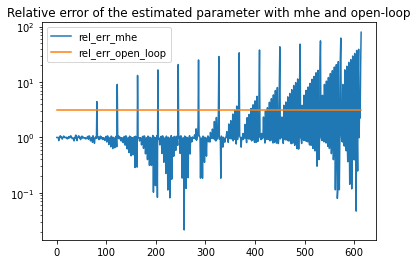

In [33]:
## relative error
## for d1:
rel_err1 = np.zeros(p_plot1.size()[0])
for i in x_ax:
    rel_err1[i]=np.abs(p_plot1[i]-p_ref1[i])/p_ref1[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err1)

rel_err2 = np.zeros(p_plot1.size()[0])
for i in x_ax:
    rel_err2[i]=np.abs(p_open_loop1[i]-p_ref1[i])/p_ref1[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err2)

plt.plot(x_ax, rel_err1, label='rel_err_mhe')
plt.plot(x_ax, rel_err2, label = 'rel_err_open_loop')
plt.yscale('log')
plt.title('Relative error of the estimated parameter with mhe and open-loop')
plt.legend()